<a href="https://colab.research.google.com/github/gtsagkatakis/UCMerced_classification_tutorial/blob/main/Tutorial2023_Denoising_UCMerced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A simple U-NET for denoising remote sensing RGB images

Connect google colab with google drive for loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load minimal libraries

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

Load the images and resize them to 128x128x3  

In [ ]:
images = np.load('/content/drive/MyDrive/@Presentations/USC_7_2023/Code/DL_tutorial_RS/DL_tutorial_RS_shared/data/UCMerced_images_orig.npy')
new_shape = (128, 128)
resized_images = tf.image.resize(images, new_shape)
x_clean = tf.cast(resized_images, tf.uint8).numpy()


Code for introducing noise to images

In [ ]:
import numpy as np

def add_noise(img, noise_factor):
    ''' Adds Gaussian noise to an image.

    img: is the clean image
    noise_factor: is a multiplier that determines the intensity of noise.

    returns a noisy image
    '''
    noisy_img = img + np.random.randn(*img.shape) * noise_factor
    noisy_img = np.clip(noisy_img, 0.0, 255.0)
    return noisy_img


x_noisy = add_noise(x_clean, noise_factor=20)

#x_val_clean = X_test  # your clean images go here
#x_val_noisy = add_noise(x_val_clean, noise_factor=0.5)


SPlit into training and validation set

In [ ]:
from sklearn.model_selection import train_test_split

# Assume x_clean is your array of clean images and x_noisy is your array of noisy images
x_noisy_train, x_noisy_val, x_clean_train, x_clean_val = train_test_split(x_noisy, x_clean, test_size=0.2, random_state=42)

# x_noisy_train and x_clean_train now contain the training data,
# and x_noisy_val and x_clean_val contain the validation data.


Show some examples

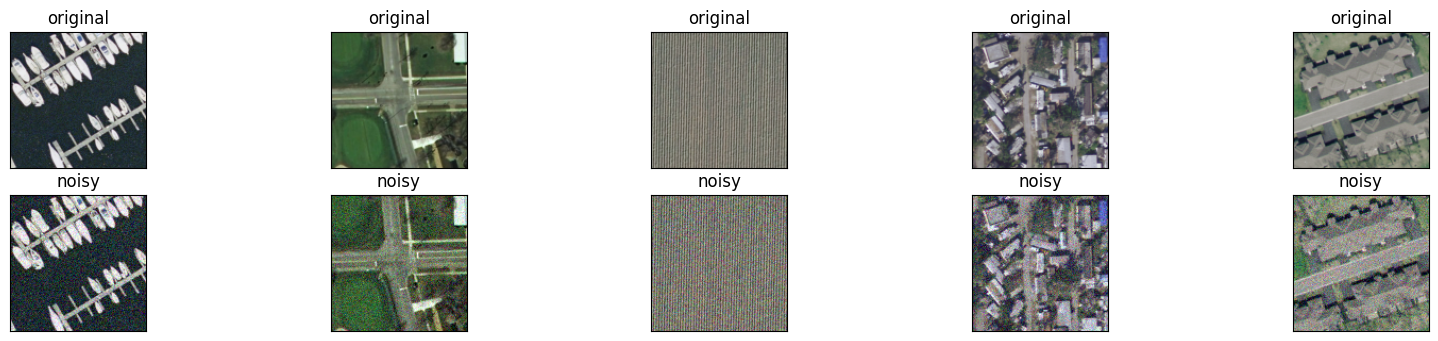

In [ ]:
import matplotlib.pyplot as plt

n = 5

plt.figure(figsize=(20, 6))

x_val_noisy_uint8 = x_noisy_val.astype('uint8')


for i in range(n):
    # display original (clean) images
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_clean_val[i])
    plt.title("original")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display noisy images
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(x_val_noisy_uint8[i])
    plt.title("noisy")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



plt.show()

Build the U-NET model

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.models import Model

def build_unet(input_shape):
    # Input Layer
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

    # Expanding Path
    up4 = concatenate([UpSampling2D((2, 2))(conv3), conv2])
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)

    up5 = concatenate([UpSampling2D((2, 2))(conv4), conv1])
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)

    # Output Layer
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv5)

    return Model(inputs, outputs)

# Input shape should match the shape of your images. If your images are 128x128 color images, use (128, 128, 3)
input_shape = (128, 128, 3)
unet = build_unet(input_shape)
unet.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 64)  0           ['conv2d_6[0][0]']               
                                                                                            

Normalize the images to [0,1]

In [ ]:
x_noisy_train=x_noisy_train/255.0
x_clean_train=x_clean_train/255.0
x_noisy_val=x_noisy_val/255.0
x_clean_val=x_clean_val/255.0

Load a pre-trained model

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
unet = load_model('/content/drive/MyDrive/@Presentations/USC_7_2023/Code/Unetweights/unet_model.h5')

Train the model

In [ ]:
history = unet.fit(x_noisy_train, x_clean_train, batch_size=64, epochs=2, validation_data=(x_noisy_val, x_clean_val))

Epoch 1/2
27/27 [==============================] - 12s 366ms/step - loss: 9.7254e-04 - val_loss: 9.8265e-04
Epoch 2/2
27/27 [==============================] - 9s 348ms/step - loss: 9.6729e-04 - val_loss: 9.7825e-04


Save the trained data

In [ ]:
#unet.save('/content/drive/MyDrive/@Presentations/USC_7_2023/Code/Unetweights/unet_model.h5')

Apply denoising to validataion set

In [ ]:
x_val_denoised = unet.predict(x_noisy_val)


14/14 [==============================] - 1s 54ms/step


In [ ]:
x_noisy_val_uint8 = (x_noisy_val * 255).astype('uint8')
x_val_denoised_uint8 = (x_val_denoised * 255).astype('uint8')

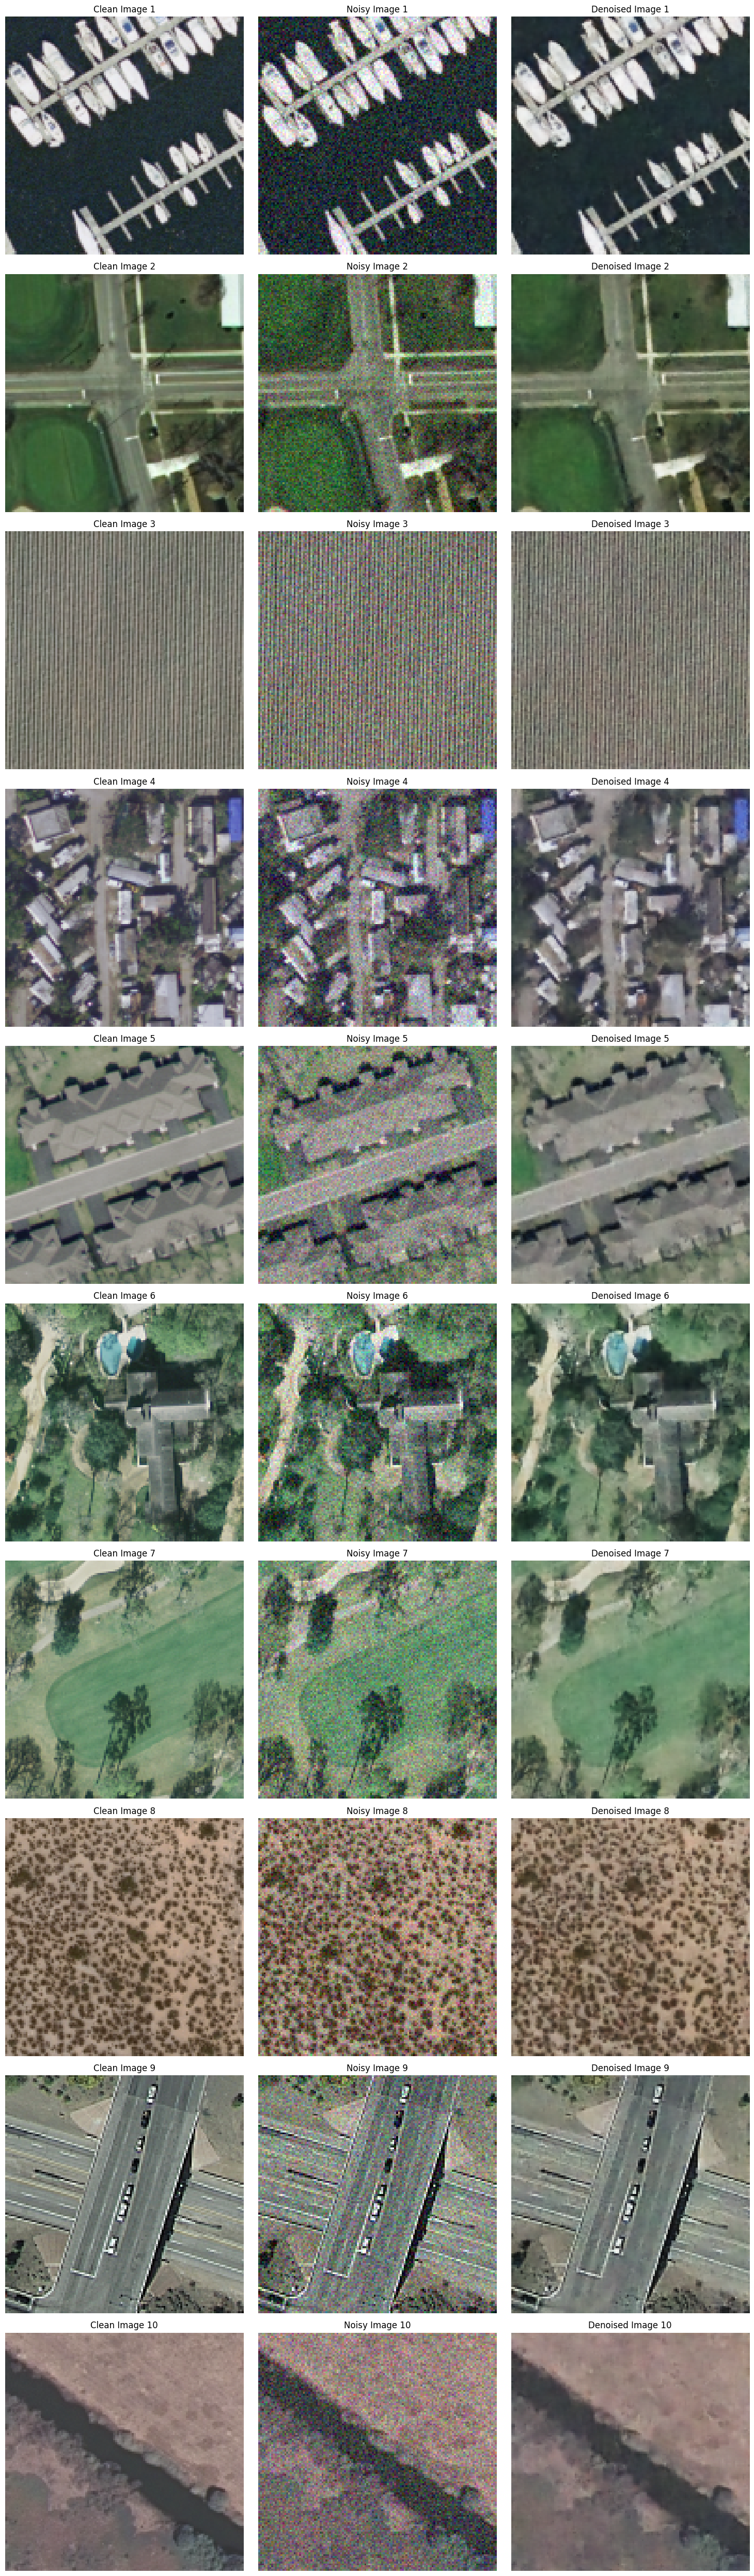

In [ ]:
import matplotlib.pyplot as plt

# assuming img_clean, img_noisy, img_denoised are your images arrays of shape (num_images, height, width, channels)
num_examples = 10

fig, axs = plt.subplots(num_examples, 3, figsize=(15, 50))  # changed the subplot structure here

for i in range(num_examples):

    axs[i, 0].imshow(x_clean_val[i])
    axs[i, 0].set_title('Clean Image {}'.format(i+1))
    axs[i, 0].axis('off')

    axs[i, 1].imshow(x_noisy_val_uint8[i])
    axs[i, 1].set_title('Noisy Image {}'.format(i+1))
    axs[i, 1].axis('off')

    axs[i, 2].imshow(x_val_denoised_uint8[i])
    axs[i, 2].set_title('Denoised Image {}'.format(i+1))
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()


PSNR:  30.382841


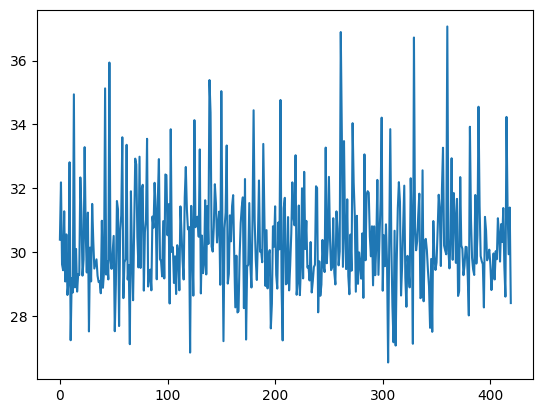

In [ ]:
import tensorflow as tf

def calculate_psnr(img1, img2):
    # Convert images to float32
    img1 = tf.image.convert_image_dtype(img1, dtype=tf.float32)
    img2 = tf.image.convert_image_dtype(img2, dtype=tf.float32)

    # Calculate PSNR
    psnr = tf.image.psnr(img1, img2, max_val=1.0)
    return psnr

# Assume y_true and y_pred are your true and predicted images, respectively
psnr_result = calculate_psnr(x_clean_val, x_val_denoised)
print("PSNR: ", psnr_result.numpy().mean())
plt.plot(psnr_result)
